In [31]:
#pip install torch torchvision torchsummary

In [32]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn

# Step 1: Choose a Pre-trained Model
import torchvision.models as models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the model and move it to the appropriate device (GPU or CPU)
model = models.googlenet(pretrained=True).to(device)

print(model)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [33]:
# Step 2: Load and modify the model

num_classes = 4
batch_size = 32
num_epochs = 5
learning_rate = 0.001

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)

print(model)

def test(model, test_loader, device):
    # Set Model to evaluation mode
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            _, predicted = torch.max(predicted_output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total * 100
    return acc

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [34]:
# Step 3: Freeze the pretrained model

# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the fully connected layer (classifier)
for param in model.fc.parameters():
    param.requires_grad = True


In [35]:
# Step 4: Data Preprocessing

import torchvision.transforms as transforms

transform = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

transformation = torchvision.transforms.Compose(transform)

data_path = 'AugmentedAlzheimerDataset'#v2 before this

full_dataset = torchvision.datasets.ImageFolder(root=data_path,
                                 transform=transformation)

train_size = int(0.7 * len(full_dataset))  # 70% data will be trained
test_size = len(full_dataset) - train_size  # 30% data will be tested
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])



# Train Loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Test Loader
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')
    


Training dataset size: 23784
Testing dataset size: 10194


In [36]:
# Step 5: Model Training

# Loss & Optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Train the model

epoch_loss = 0
loss_list = []
training_loss = []
training_acc = []
epoch_nums = []

model.train()

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Move data to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)  # No need to one-hot encode if using CrossEntropyLoss
        
        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        loss_list.append(epoch_loss)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / (i + 1)
    training_loss.append(avg_loss)

    # Calculate accuracy
    accuracy = test(model, test_loader, device)
    training_acc.append(accuracy)

    epoch_nums.append(epoch)
    epoch_loss = 0


Epoch [1/5], Step [100/744], Loss: 1.1129
Epoch [1/5], Step [200/744], Loss: 1.1837
Epoch [1/5], Step [300/744], Loss: 1.1852
Epoch [1/5], Step [400/744], Loss: 0.9096
Epoch [1/5], Step [500/744], Loss: 0.9632
Epoch [1/5], Step [600/744], Loss: 1.0185
Epoch [1/5], Step [700/744], Loss: 1.1326
Epoch [2/5], Step [100/744], Loss: 0.8278
Epoch [2/5], Step [200/744], Loss: 0.9010
Epoch [2/5], Step [300/744], Loss: 1.0888
Epoch [2/5], Step [400/744], Loss: 0.6896
Epoch [2/5], Step [500/744], Loss: 0.6660
Epoch [2/5], Step [600/744], Loss: 1.0497
Epoch [2/5], Step [700/744], Loss: 0.8245
Epoch [3/5], Step [100/744], Loss: 0.8197
Epoch [3/5], Step [200/744], Loss: 0.8479
Epoch [3/5], Step [300/744], Loss: 0.8383
Epoch [3/5], Step [400/744], Loss: 0.8990
Epoch [3/5], Step [500/744], Loss: 1.0198
Epoch [3/5], Step [600/744], Loss: 0.6752
Epoch [3/5], Step [700/744], Loss: 0.8823
Epoch [4/5], Step [100/744], Loss: 0.8146
Epoch [4/5], Step [200/744], Loss: 0.6957
Epoch [4/5], Step [300/744], Loss:

In [37]:
# Set Model to evaluation mode
model.eval

with torch.no_grad():
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predicted_output = model(images)
    _,predicted = torch.max(predicted_output.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = correct /total *100
print(acc)


# making predction based on the test dataset


64.6262507357269


In [38]:
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store predictions and true labels
y_pred = []
y_true = []

# Set model to evaluation mode
model.eval()

# Disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        predicted_output = model(images)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(predicted_output, 1)
        
        # Store predictions and true labels in lists
        y_pred.extend(predicted.cpu().numpy())  # Move predictions to CPU
        y_true.extend(labels.cpu().numpy())    # Move true labels to CPU

# Calculate confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cf_matrix)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[1547  170  588  413]
 [  40 1816   42   22]
 [ 229   63 2278  287]
 [ 507   97 1148  947]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.61      2718
           1       0.85      0.95      0.89      1920
           2       0.56      0.80      0.66      2857
           3       0.57      0.35      0.43      2699

    accuracy                           0.65     10194
   macro avg       0.66      0.67      0.65     10194
weighted avg       0.64      0.65      0.63     10194



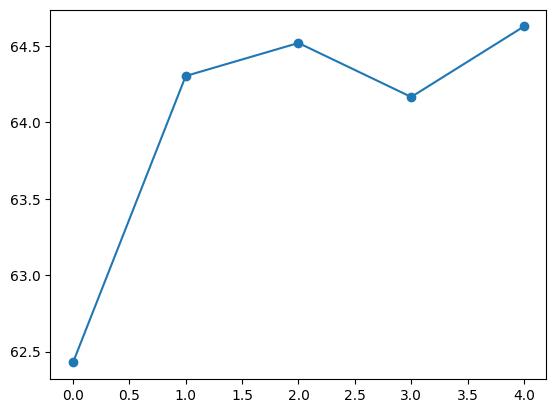

[0, 1, 2, 3, 4] [62.42887973317638, 64.30253090052972, 64.51834412399451, 64.16519521287032, 64.6262507357269]


In [43]:
plt.plot(epoch_nums, training_acc, marker='o')
plt.show()

print(epoch_nums, training_acc)

[1.4340120553970337, 2.7722889184951782, 4.144573450088501, 5.657972574234009, 6.986652135848999, 8.409011483192444, 9.863226890563965, 11.226080060005188, 12.550066947937012, 13.91174864768982, 15.272469758987427, 16.755806922912598, 18.14274835586548, 19.569137692451477, 20.89548134803772, 22.21473515033722, 23.57423686981201, 24.862930417060852, 26.2383953332901, 27.6087064743042, 28.946227073669434, 30.234341859817505, 31.558265328407288, 32.9492062330246, 34.24693405628204, 35.58352315425873, 36.90488398075104, 38.10260367393494, 39.26300847530365, 40.523677587509155, 41.73829436302185, 43.01063597202301, 44.293567538261414, 45.53670370578766, 46.69434571266174, 47.99757754802704, 49.329124331474304, 50.66124963760376, 51.875885367393494, 53.00583231449127, 54.2521094083786, 55.526299595832825, 56.75587069988251, 57.95969760417938, 59.20104932785034, 60.52373242378235, 61.75719237327576, 62.88535976409912, 64.00135886669159, 65.17795300483704, 66.41216504573822, 67.59245455265045,

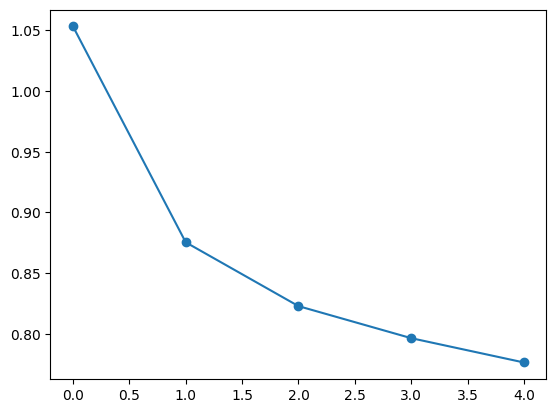

[0, 1, 2, 3, 4] [1.053200613026337, 0.8752990481193348, 0.8227233103206081, 0.7963139312241667, 0.7762749329690011]


In [44]:
print(loss_list)

#plt.plot(loss_list)
plt.plot(training_loss, marker='o')
plt.show()

print(epoch_nums, training_loss)

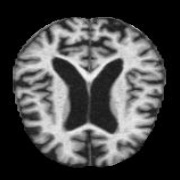

torch.Size([1, 3, 224, 224])
tensor([1], device='cuda:0')
ModerateDemented


In [41]:
model.eval()  # Switch model to evaluation mode

from PIL import Image

# Open the image and convert to RGB
img = Image.open('images/moderate.jpg').convert('RGB')

# Display the image (use .show() instead of display)
display(img)

# Define the transformations
transforms = [torchvision.transforms.Resize((224, 224)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

# Compose the transformations
transformations = torchvision.transforms.Compose(transforms)

# Apply the transformations to the image
transformed = transformations(img)

# Add batch dimension (unsqueeze)
transformed = transformed.unsqueeze(0)

# Check the size of the tensor
print(transformed.size())

# Move the transformed image to the same device as the model (GPU or CPU)
transformed = transformed.to(device)

# Pass the transformed image through the model
predicted_output = model(transformed)

# Get the predicted class
_, predicted = torch.max(predicted_output, 1)

# Print the predicted class index
print(predicted)

# Convert the predicted class index to a class name
predicted = predicted.cpu().data.numpy()[0]

# Print the predicted class label
print(classes[predicted])


In [42]:
torch.save(model.state_dict(), "googleNet.pth")